In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import pickle
import glob
import os
from scipy.interpolate import interp1d
# from pyomo import *

In [8]:
import scipy
scipy.__version__

'1.3.0'

In [10]:
with open('./IntermediateData/generationMatrix.pickle', 'rb') as pickleFile:
    genMatrix = pickle.load(pickleFile)

In [11]:
### Lets work in GW
genMatrix = genMatrix/1000.
genTypes = ['CCGT', 'COAL', 'INTEW', 'INTFR', 'INTIRL', 'INTNED', 'NPSHYD', 'NUCLEAR', \
            'OCGT', 'OIL', 'OTHER', 'PS', 'WIND']

In [12]:
demand = np.sum(genMatrix, axis=1)

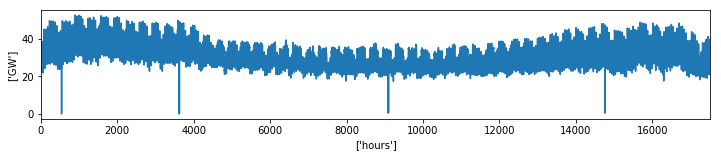

In [13]:
fig = plt.figure(figsize=(12,2))
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(0,len(demand)),demand)
ax1.set_xlim([0,17520])
ax1.set_xlabel(['hours']);
ax1.set_ylabel(['GW']);

### This looks as though there are errors
* clean up the places with unreasonably low demand by interpolation

In [14]:
badIndices = np.where(demand<16)[0]
len( badIndices )

12

In [15]:
demand[14757:14763]

array([27.92 , 39.976,  0.389, 41.409,  0.396, 41.281])

In [16]:
badIndices = np.array([541, 542, 543, 544, 546, 3622, 3623, 3625, 9092, 9093,\
        9095, 14757, 14759, 14761])

In [17]:
# interpolate the bad results based on previous and next hours
windows = [[530,555], [3615,3635], [9085,9105], [14750,14770]]

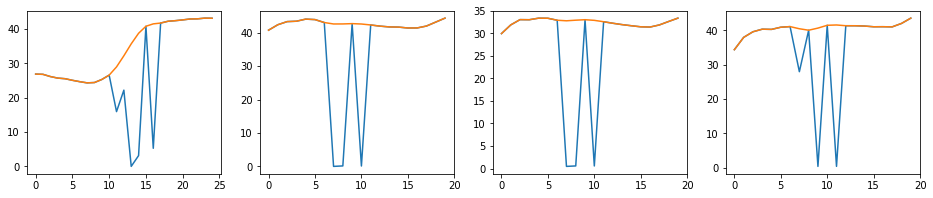

In [18]:
fig = plt.figure(figsize = (16,3))
axs = []
for j in range(4):
    ax = fig.add_subplot(1,4,j+1)
    axs.append(ax)

    
for k in range(13):
    genMatrix[badIndices,k]=np.nan
    for j,window in enumerate(windows):
        test = genMatrix[window[0]:window[1],k]
        timeWindow = np.arange(0, len(test))
        hours = timeWindow[~np.isnan(test)]
        test = test[~np.isnan(test)]
        # now let's interp this
        f1 = interp1d(hours, test, kind='cubic')
        # now include the interp values
        genMatrix[window[0]:window[1],k] = f1(timeWindow)

for j,window in enumerate(windows):
    timeWindow = np.arange(0, len(demand[window[0]:window[1]]))
    axs[j].plot(timeWindow, demand[window[0]:window[1]])
    
demand[badIndices] = np.sum(genMatrix[badIndices,:], axis=1)
for j,window in enumerate(windows):
    timeWindow = np.arange(0, len(demand[window[0]:window[1]]))
    axs[j].plot(timeWindow, demand[window[0]:window[1]])
    

In [19]:
fs = 10

def demand_histogram(demand):
    upperVal = np.ceil(np.max(demand)/1)*1
    lowerVal = np.floor(np.min(demand)/1)*1
    demandBins = np.arange(lowerVal, upperVal+1, 1)
    hist, edges = np.histogram(demand, bins=demandBins)
    centres = edges[0:-1]+(edges[1:]-edges[0:-1])/2.
    widths = edges[1:]-edges[0:-1]
    return hist, centres, widths

def wind_histogram(demand):
    upperVal = np.ceil(np.max(demand)/10)*10
    lowerVal = np.floor(np.min(demand)/10)*10
    demandBins = np.arange(lowerVal, upperVal+1, 0.1)
    hist, edges = np.histogram(demand, bins=demandBins)
    centres = edges[0:-1]+(edges[1:]-edges[0:-1])/2.
    widths = edges[1:]-edges[0:-1]
    return hist, centres, widths

def axis_format(axis, labX, labY, fs):
    axis.set_xlabel(labX, fontsize=fs)
    axis.set_ylabel(labY, fontsize=fs)
    axis.tick_params(axis='both', labelsize=fs)
    
def dispatch_by_demand(demand, genMatrix):
    upperVal = np.ceil(np.max(demand))
    lowerVal = np.floor(np.min(demand))
    demandBins = np.arange(lowerVal, upperVal+1, 1)
    marks = np.digitize(demand, demandBins)
    dispatchAverage = np.zeros((len(demandBins[:-1]),np.size(genMatrix, 1)))
    for j in set(marks):
        dispatchAverage[j-1]=np.mean(genMatrix[np.where(marks==j)[0]], axis=0)
    widths = (demandBins[1:]-demandBins[0:-1])/2
    centres = demandBins[0:-1]+widths
    return centres, dispatchAverage

def average_day(demand, genMatrix,noPeriods):
    noDays = np.int( len(genMatrix)/noPeriods )
    test = np.zeros((noDays, noPeriods, np.size(genMatrix, 1)))
    for day in range(noDays):
        test[day,:,:] = genMatrix[day*noPeriods:day*noPeriods+noPeriods,:]
    averageDay = np.mean(test,axis=0)
    return averageDay


In [20]:
np.shape(genMatrix)

(17520, 13)

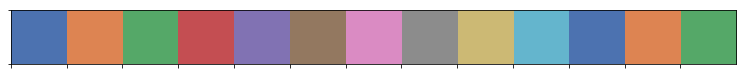

In [21]:
colors = sns.color_palette('deep', 13)
sns.palplot(colors)

### plot yearly demand distribution, dispatch by demand and average day

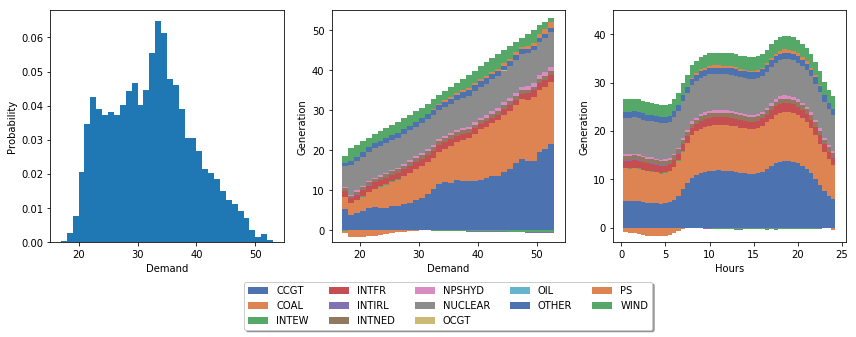

In [22]:
hist, centres, widths = demand_histogram(demand)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths)
labX = 'Demand'
labY = 'Probability'
axis_format(ax1, labX, labY, fs)

centres, dispatchAverage = dispatch_by_demand(demand, genMatrix)
ax2 = fig.add_subplot(132)
bottomsPos = np.zeros(len(dispatchAverage))
bottomsNeg = np.zeros(len(dispatchAverage))
for col in range(np.size(dispatchAverage,1)):
    d = dispatchAverage[:,col]
    posVal = np.zeros(np.shape(d))
    negVal = np.zeros(np.shape(d))
    posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
    negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
    ax2.bar(centres, posVal, bottom=bottomsPos, width=1, color=colors[col])
    ax2.bar(centres, negVal, bottom=bottomsNeg, width=1, color=colors[col])
    bottomsPos+=posVal
    bottomsNeg+=negVal
ax2.set_ylim([-3,55])
labX = 'Demand'
labY = 'Generation'
axis_format(ax2, labX, labY, fs)

averageDay = average_day(demand, genMatrix, 48)
times = np.arange(0.5,24.1,0.5)
ax3 = fig.add_subplot(133)
bottomsPos = np.zeros(len(averageDay))
bottomsNeg = np.zeros(len(averageDay))
for col in range(np.size(averageDay,1)):
    d = averageDay[:,col]
    posVal = np.zeros(np.shape(d))
    negVal = np.zeros(np.shape(d))
    posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
    negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
    ax3.bar(times, posVal, bottom=bottomsPos, width=0.5, color=colors[col])
    ax3.bar(times, negVal, bottom=bottomsNeg, width=0.5, color=colors[col])
    bottomsPos+=posVal
    bottomsNeg+=negVal
ax3.set_ylim([-3,45])
labX = 'Hours'
labY = 'Generation'
axis_format(ax3, labX, labY, fs)
    

fig.tight_layout()

# Put a legend below current axis
rects = []
for col in range(np.size(dispatchAverage,1)):
    r = plt.Rectangle((0, 0), 1, 1, fc=colors[col], alpha=1)
    rects.append(r)
ax2.legend(rects, genTypes, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
fig.savefig('figureGenByTypeData.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', bbox_inches='tight')

### strip out wind and interconnectors

In [23]:
### we want to focus on dispatch and demand within the national block
### therefore, we strip out wind which isn't dispatchable and interconnectors

In [24]:
### form a matrix of nuclear, hydro, coal, CCGT, other, Oil+OCGT, PS, Interconnectors, Wind
genMatrixR = np.zeros((np.size(genMatrix, 0),9))
genMatrixR[:,0] = genMatrix[:,7]
genMatrixR[:,1] = genMatrix[:,6]
genMatrixR[:,2] = genMatrix[:,1]
genMatrixR[:,3] = genMatrix[:,0]
genMatrixR[:,4] = genMatrix[:,10]
genMatrixR[:,5] = genMatrix[:,8]+genMatrix[:,9]
genMatrixR[:,6] = genMatrix[:,11]
genMatrixR[:,7] = genMatrix[:,5]+genMatrix[:,4]+genMatrix[:,3]+genMatrix[:,2]
genMatrixR[:,8] = genMatrix[:,12]

In [25]:
wind = genMatrixR[:,8]
interconnectors = genMatrixR[:,7]
PS = genMatrixR[:,6]

### INTERCONECTORS
# when intercon is negative, demand is lowered
# when intercon is positive, demand is raised
# to get the demand met inside the national block, we can neglect interconnectors
# essentially, this assumes that -ve interconnection is demand which must be provided for
# and positive is demand which doesn't have to be provided

### WIND
# consider demand net of wind

### PS
# exclude PS - so we are ignoring the contribution it makes but considering the charging

genMatrixR = genMatrixR[:,0:6]
demand = np.sum(genMatrixR, axis=1)+wind
demandNetWind = demand - wind
genTypesR = ['nuclear',  'hydro', 'coal', 'CCGT', 'other', 'OCGT']

In [26]:
### plot a yearly generation vs demand plot

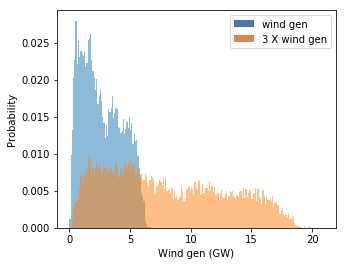

In [27]:
### wind figures for presentation
hist, centres, widths = wind_histogram(wind)
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths, alpha=0.5)

hist, centres, widths = wind_histogram(3*wind)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths, alpha=0.5)

labX = 'Wind gen (GW)'
labY = 'Probability'
axis_format(ax1, labX, labY, fs)
r1 = plt.Rectangle((0, 0), 1, 1, fc=colors[0], alpha=1)
r2 = plt.Rectangle((0, 0), 1, 1, fc=colors[1], alpha=1)
ax1.legend([r1,r2],['wind gen','3 X wind gen'])

Text(0, 0.5, 'GW')

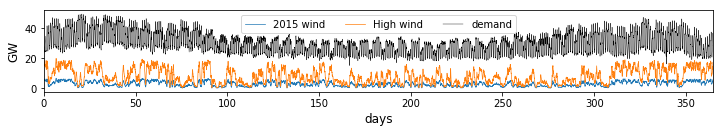

In [28]:
fig = plt.figure(figsize=(12,1.5))
ax1 = fig.add_subplot(111)
l1, = ax1.plot(np.arange(0,len(demand))/48,wind,linewidth=0.7)
l2, = ax1.plot(np.arange(0,len(demand))/48,wind*3,linewidth=0.7)
l3, = ax1.plot(np.arange(0,len(demand))/48,demand,color='k',linewidth=0.4)
ax1.set_xlim([0,365])
ax1.legend([l1,l2,l3],['2015 wind', 'High wind', 'demand'],ncol=3)
ax1.set_xlabel('days', fontsize=12)
ax1.set_ylabel('GW', fontsize=12)

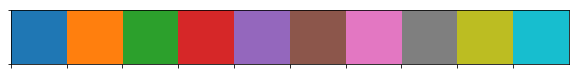

In [29]:
colors = sns.color_palette()
sns.palplot(colors)

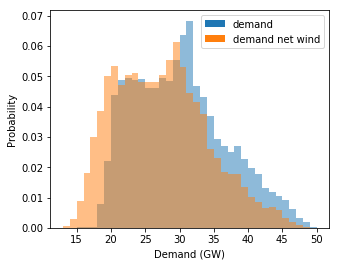

In [30]:
hist, centres, widths = demand_histogram(demand)
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths, alpha=0.5)

hist, centres, widths = demand_histogram(demandNetWind)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths, alpha=0.5)

labX = 'Demand (GW)'
labY = 'Probability'
axis_format(ax1, labX, labY, fs)
r1 = plt.Rectangle((0, 0), 1, 1, fc=colors[0], alpha=1)
r2 = plt.Rectangle((0, 0), 1, 1, fc=colors[1], alpha=1)
ax1.legend([r1,r2],['demand','demand net wind'])

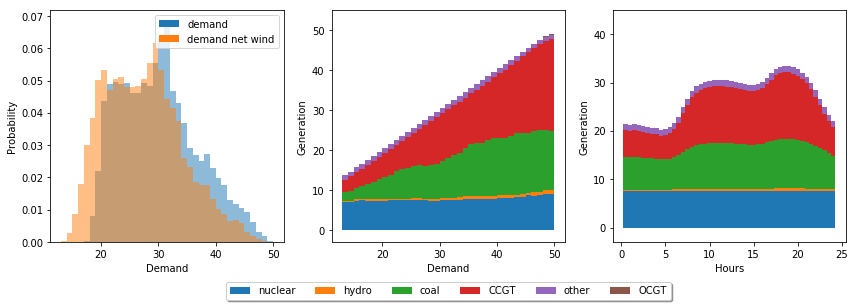

In [31]:
hist, centres, widths = demand_histogram(demand)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths, alpha=0.5)

hist, centres, widths = demand_histogram(demandNetWind)
ax1.bar(centres, hist/np.float(np.sum(hist)), width=widths, alpha=0.5)

labX = 'Demand'
labY = 'Probability'
axis_format(ax1, labX, labY, fs)
r1 = plt.Rectangle((0, 0), 1, 1, fc=colors[0], alpha=1)
r2 = plt.Rectangle((0, 0), 1, 1, fc=colors[1], alpha=1)
ax1.legend([r1,r2],['demand','demand net wind'])


centres, dispatchAverage = dispatch_by_demand(demandNetWind, genMatrixR)
ax2 = fig.add_subplot(132)
bottomsPos = np.zeros(len(dispatchAverage))
bottomsNeg = np.zeros(len(dispatchAverage))
for col in range(np.size(dispatchAverage,1)):
    d = dispatchAverage[:,col]
    posVal = np.zeros(np.shape(d))
    negVal = np.zeros(np.shape(d))
    posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
    negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
    ax2.bar(centres, posVal, bottom=bottomsPos, width=1, color=colors[col])
    ax2.bar(centres, negVal, bottom=bottomsNeg, width=1, color=colors[col])
    bottomsPos+=posVal
    bottomsNeg+=negVal
ax2.set_ylim([-3,55])
labX = 'Demand'
labY = 'Generation'
axis_format(ax2, labX, labY, fs)

averageDay = average_day(demandNetWind, genMatrixR, 48)
times = np.arange(0.5,24.1,0.5)
ax3 = fig.add_subplot(133)
bottomsPos = np.zeros(len(averageDay))
bottomsNeg = np.zeros(len(averageDay))
for col in range(np.size(averageDay,1)):
    d = averageDay[:,col]
    posVal = np.zeros(np.shape(d))
    negVal = np.zeros(np.shape(d))
    posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
    negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
    ax3.bar(times, posVal, bottom=bottomsPos, width=0.5, color=colors[col])
    ax3.bar(times, negVal, bottom=bottomsNeg, width=0.5, color=colors[col])
    bottomsPos+=posVal
    bottomsNeg+=negVal
ax3.set_ylim([-3,45])
labX = 'Hours'
labY = 'Generation'
axis_format(ax3, labX, labY, fs)
    

fig.tight_layout()

# Put a legend below current axis
rects = []
for col in range(np.size(dispatchAverage,1)):
    r = plt.Rectangle((0, 0), 1, 1, fc=colors[col], alpha=1)
    rects.append(r)
ax2.legend(rects, genTypesR, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=6)

In [32]:
for j,genType in enumerate(genTypesR):
    oneGenType = genMatrixR[:,j].reshape(365,48)
    averageDay = np.mean(oneGenType, axis=0)
    print( 'The min '+genType+' generation is %.2f'%(np.min(averageDay))+', the max is %.2f'%(np.max(averageDay)) )
print ('')
for j,genType in enumerate(genTypesR):
    oneGenType = genMatrixR[:,j].reshape(365,48)
    maxDay = np.max(oneGenType, axis=0)
    print( 'The min '+genType+' generation is %.2f'%(np.min(maxDay))+', the max is %.2f'%(np.max(maxDay)) )

The min nuclear generation is 7.48, the max is 7.52
The min hydro generation is 0.34, the max is 0.65
The min coal generation is 6.24, the max is 10.17
The min CCGT generation is 4.95, the max is 13.80
The min other generation is 1.25, the max is 1.33
The min OCGT generation is 0.00, the max is 0.01

The min nuclear generation is 8.97, the max is 9.01
The min hydro generation is 0.93, the max is 1.11
The min coal generation is 14.47, the max is 17.76
The min CCGT generation is 8.79, the max is 22.89
The min other generation is 2.42, the max is 2.44
The min OCGT generation is 0.01, the max is 0.61


In [33]:
### print average daily min, average daily max and the difference between these two for each season

In [34]:
Winter_start = 0
Winter_end = (np.round(365/4)+1)*48
Spring_start = Winter_end
Spring_end = Winter_end + np.round(365/4)*48
Summer_start = Spring_end
Summer_end = Spring_end + np.round(365/4)*48
Autumn_start = Summer_end
Autumn_end = Summer_end + np.round(365/4)*48

seasonMarkers = np.array([Winter_start, Spring_start, Summer_start, Autumn_start, Autumn_end])
seasonMarkers = np.asarray([np.int(s) for s in seasonMarkers])
seasons = ['winter', 'spring', 'summer', 'autumn']
for season in range(4):
    if season==0:
        start_index = 0
        end_index = Winter_end/48
    elif season == 1:
        end_index = (Spring_end-Winter_end)/48
        start_index = Winter_end/48
    elif season == 2:
        end_index = (Summer_end-Spring_end)/48
        start_index = Spring_end/48
    else:
        end_index = (Autumn_end-Summer_end)/48
        start_index = Summer_end/48
    start_index = np.int(start_index)
    end_index = np.int(end_index)
    print( 'For season '+seasons[season] )
    
    for j,genType in enumerate(genTypesR):
        oneGenType = genMatrixR[start_index*48:start_index*48+end_index*48,j].reshape(end_index,48)
        averageDay = np.mean(oneGenType, axis=0)
        print( 'The min '+genType+' generation is %.2f'%(np.min(averageDay))+', the max is %.2f'%(np.max(averageDay)) )

For season winter
The min nuclear generation is 7.79, the max is 7.83
The min hydro generation is 0.50, the max is 0.88
The min coal generation is 10.38, the max is 15.00
The min CCGT generation is 3.92, the max is 15.17
The min other generation is 0.93, the max is 1.01
The min OCGT generation is -0.00, the max is 0.01
For season spring
The min nuclear generation is 7.20, the max is 7.28
The min hydro generation is 0.28, the max is 0.56
The min coal generation is 5.81, the max is 8.48
The min CCGT generation is 5.09, the max is 11.55
The min other generation is 0.92, the max is 1.00
The min OCGT generation is 0.00, the max is 0.00
For season summer
The min nuclear generation is 7.00, the max is 7.04
The min hydro generation is 0.17, the max is 0.42
The min coal generation is 3.91, the max is 6.87
The min CCGT generation is 5.91, the max is 13.11
The min other generation is 1.27, the max is 1.34
The min OCGT generation is 0.00, the max is 0.00
For season autumn
The min nuclear generatio

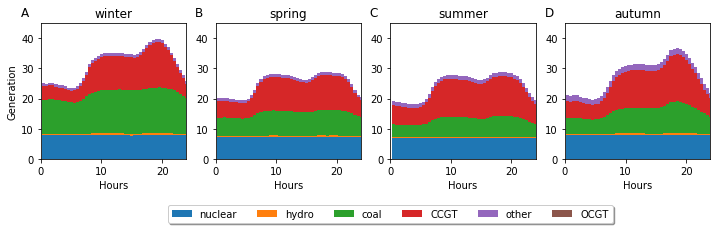

In [35]:
### plot the average daily dispatch in all seasons
figLabels = ['A', 'B', 'C', 'D']

fig = plt.figure(figsize=(12,2.5))
axs = []
for j in range(4):
    ax = fig.add_subplot(1,4,j+1)
    axs.append( ax )

for season in range(4):
    if season==0:
        start_index = 0
        end_index = Winter_end/48
    elif season == 1:
        end_index = (Spring_end-Winter_end)/48
        start_index = Winter_end/48
    elif season == 2:
        end_index = (Summer_end-Spring_end)/48
        start_index = Spring_end/48
    else:
        end_index = (Autumn_end-Summer_end)/48
        start_index = Summer_end/48
    start_index = np.int(start_index)
    end_index = np.int(end_index)
    
    test = genMatrixR[start_index*48:start_index*48+end_index*48,:]
    testDemand = demandNetWind[start_index*48:start_index*48+end_index*48]
    averageDay = average_day(testDemand, test, 48)
    
    times = np.arange(0.5,24.1,0.5)
    bottomsPos = np.zeros(len(averageDay))
    bottomsNeg = np.zeros(len(averageDay))
    for col in range(np.size(averageDay,1)):
        d = averageDay[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        axs[season].bar(times, posVal, bottom=bottomsPos, width=0.5, color=colors[col])
        axs[season].bar(times, negVal, bottom=bottomsNeg, width=0.5, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
        
    axs[season].set_ylim([0,45])
    labX = 'Hours'
    if season == 0:
        labY = 'Generation'
    else:
        labY = ''
    axs[season].set_xlim([0,24])
    axis_format(axs[season], labX, labY, fs)
    
    axs[season].text(-0.14, 1.05, figLabels[season], transform=axs[season].transAxes, fontsize=fs+2) 
    axs[season].set_title(seasons[season])
    
labZW = ['nuclear', 'hydro', 'coal', 'CCGT', 'other', 'OCGT']
rects = []
for col in range(6):
    r = plt.Rectangle((0, 0), 1, 1, fc=colors[col], alpha=1)
    rects.append(r)
axs[1].legend(rects, labZW, loc='upper center', bbox_to_anchor=(1.2, -0.3),
          fancybox=True, shadow=True, ncol=7)
    
fig.subplots_adjust(wspace=0.2)

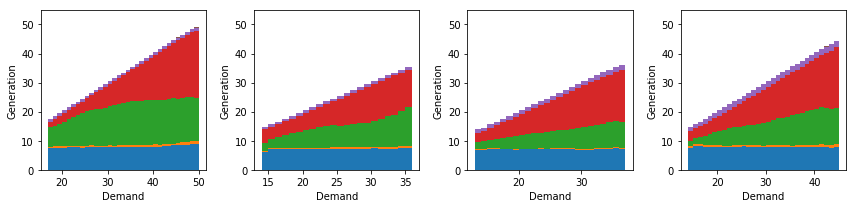

In [36]:
### plot seasonal generation vs demand plots

fig = plt.figure(figsize=(12,3))
axs = []
for j in range(4):
    ax = fig.add_subplot(1,4,j+1)
    axs.append( ax )

for season in range(4):
    if season==0:
        start_index = 0
        end_index = Winter_end/48
    elif season == 1:
        end_index = (Spring_end-Winter_end)/48
        start_index = Winter_end/48
    elif season == 2:
        end_index = (Summer_end-Spring_end)/48
        start_index = Spring_end/48
    else:
        end_index = (Autumn_end-Summer_end)/48
        start_index = Summer_end/48
    start_index = np.int(start_index)
    end_index = np.int(end_index)
    
    test = genMatrixR[start_index*48:start_index*48+end_index*48,:]
    testDemand = demandNetWind[start_index*48:start_index*48+end_index*48]
    
    centres, dispatchAverage = dispatch_by_demand(testDemand, test)
    centres, dispatchAverage = centres, dispatchAverage
    bottomsPos = np.zeros(len(dispatchAverage))
    bottomsNeg = np.zeros(len(dispatchAverage))
    for col in range(np.size(dispatchAverage,1)):
        d = dispatchAverage[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        axs[season].bar(centres, posVal, bottom=bottomsPos, width=1, color=colors[col])
        axs[season].bar(centres, negVal, bottom=bottomsNeg, width=1, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
    axs[season].set_ylim([0,55])
    labX = 'Demand'
    labY = 'Generation'
    axis_format(axs[season], labX, labY, fs)
    
fig.tight_layout()

In [37]:
### get table of the total yearly production of all gentypes
sizes = np.sum(genMatrixR[:,0:5], axis=0)
sizes = np.append(sizes, np.sum(wind))
sizes = np.append(sizes, np.sum(interconnectors))
sizes = sizes/2.

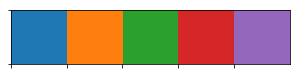

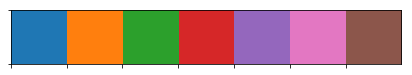

In [38]:
testColors = colors[0:5]
sns.palplot(testColors)
testColors.append(colors[6])
testColors.append(colors[5])
sns.palplot(testColors)

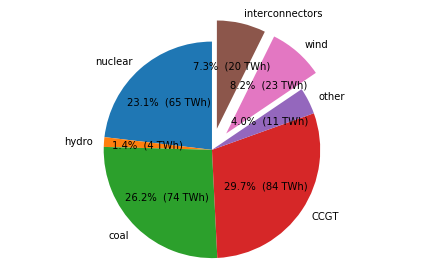

In [39]:
## Pie chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0)/1000)
        return '{p:.1f}%  ({v:d} TWh)'.format(p=pct,v=val)
        #return '({v:d} TWh)'.format(v=val)
    return my_autopct

labZ = genTypesR[0:5]
labZ.append('wind')
labZ.append('interconnectors')
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0, 0, 0, 0, 0.2, 0.2)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labZ, autopct=make_autopct(sizes), shadow=False, startangle=90, colors=testColors)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [40]:
# make a simple merit order stack
# compare that with rules
# compare with rules by season
# compare optimised

In [41]:
plantCaps = np.asarray([9.5, 1.4, 15, 29, 2, 1])
print ('The max generating capacity is %.f'%np.sum(plantCaps)+'GW')
modelMix = np.zeros((len(demand),len(plantCaps)))

The max generating capacity is 58GW


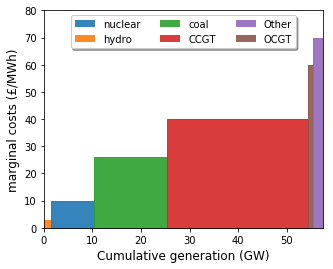

In [42]:
### plot the simple merit order stack

dummyCaps = np.asarray([1.4, 9., 15, 29, 1, 2])
dummyCosts = np.array([3.,  # hydro
                     10.,  # nuclear
                     26., # coal
                     40., # CCGT
                     60.,  # OCGT
                     70.,  # other
                     0.])  # wind

dummyColors = colors[0:8]

fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)

plantX = np.arange(0,dummyCaps[0],0.1)
ax1.fill_between(plantX, np.zeros(len(plantX)), np.ones(len(plantX))*dummyCosts[0], alpha=0.9, color=dummyColors[1])

plantX = np.arange(np.sum(dummyCaps[0:1]),np.sum(dummyCaps[0:2]),0.1)
ax1.fill_between(plantX, np.zeros(len(plantX)), np.ones(len(plantX))*dummyCosts[1], alpha=0.9, color=dummyColors[0])

plantX = np.arange(np.sum(dummyCaps[0:2]),np.sum(dummyCaps[0:3]),0.1)
ax1.fill_between(plantX, np.zeros(len(plantX)), np.ones(len(plantX))*dummyCosts[2], alpha=0.9, color=dummyColors[2])

plantX = np.arange(np.sum(dummyCaps[0:3]),np.sum(dummyCaps[0:4]),0.1)
ax1.fill_between(plantX, np.zeros(len(plantX)), np.ones(len(plantX))*dummyCosts[3], alpha=0.9, color=dummyColors[3])

plantX = np.arange(np.sum(dummyCaps[0:4]),np.sum(dummyCaps[0:5]),0.1)
ax1.fill_between(plantX, np.zeros(len(plantX)), np.ones(len(plantX))*dummyCosts[4], alpha=0.9, color=dummyColors[5])

plantX = np.arange(np.sum(dummyCaps[0:5]),np.sum(dummyCaps[0:6]),0.1)
ax1.fill_between(plantX, np.zeros(len(plantX)), np.ones(len(plantX))*dummyCosts[5], alpha=0.9, color=dummyColors[4])

ax1.set_xlim([0,np.sum(dummyCaps)])
ax1.set_ylim([0,np.max(dummyCosts)+10])

ax1.set_xlabel('Cumulative generation (GW)', fontsize=12)
ax1.set_ylabel('marginal costs (£/MWh)', fontsize=12)

rects = []
for col in range(7):
    r = plt.Rectangle((0, 0), 1, 1, fc=dummyColors[col], alpha=0.9)
    rects.append(r)
ax1.legend(rects, ['nuclear', 'hydro', 'coal', 'CCGT', 'Other', 'OCGT'], \
           loc='upper center', fancybox=True, shadow=True, ncol=3)

In [43]:
def FCEC_naive(demandPeriod, plantCaps):
    genLevels = np.zeros((len(plantCaps)))
    maxLevels = np.cumsum(plantCaps)
    
    diffs = maxLevels - demandPeriod
    marginIndex = np.where(diffs>=0)[0][0]
    
    genLevels[np.where(diffs<0)] = plantCaps[np.where(diffs<0)]
    if marginIndex>0:
        genLevels[marginIndex] = demandPeriod - maxLevels[marginIndex-1]
    else:
        genLevels[marginIndex] = demandPeriod
        
    return genLevels

In [44]:
for j in range(len(demandNetWind)):
    # get the dispatch based on the demand
    modelMix[j] = FCEC_naive(demandNetWind[j], plantCaps=plantCaps)

In [45]:
modelMixNaive = np.copy(modelMix)

In [46]:
# check totals are the same
np.round( np.sum(modelMix) - np.sum(genMatrixR), 2 )

0.0

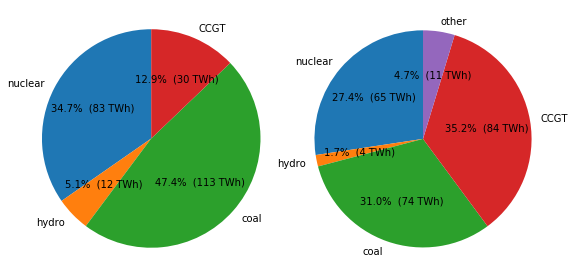

In [47]:
sizes = np.sum(genMatrixR, axis=0)/2.
sizes = sizes[0:5]
labZ = genTypesR[0:5]

explode = (0,0,0,0,0)
fig1, axs = plt.subplots(1,2)
fig1.set_size_inches(8,4)
axs[1].pie(sizes, explode=explode, labels=labZ, autopct=make_autopct(sizes), shadow=False, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
axs[1].axis('equal')

sizes = np.sum(modelMix, axis=0)/2.
sizes = sizes[0:4]
explode = (0,0,0,0)
axs[0].pie(sizes, explode=explode, labels=labZ[0:4], autopct=make_autopct(sizes), shadow=False, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
axs[0].axis('equal')

plt.tight_layout()

In [48]:
### now use rules - i.e. dispatch and baseload

plantCapsBaseload = np.asarray([[8, 1, 3, 5, 1, 0],
                      [2, 0, 12, 20, 1, 1]])

print ('The max generating capacity is %.f'%np.sum(plantCapsBaseload)+'GW')
modelMix = np.zeros((len(demand),np.size(plantCapsBaseload, 1)))

The max generating capacity is 54GW


In [49]:
def FCEC_baseload(demandPeriod, plantCapsBaseload, windPeriod):
    # get the dispatch based on the demand
    
    pC = plantCapsBaseload.astype(float)
    
    genLevels = np.zeros((np.shape(pC)))
    maxLevels = np.cumsum(pC, axis=1)
    
    # make sure demand isnt less than baseload
    if demandPeriod < maxLevels[0,-1]:
        diffs = maxLevels[0] - demandPeriod
        marginIndex = np.where(diffs>=0)[0][0]
        
        genLevels[0,np.where(diffs<0)] = pC[0,np.where(diffs<0)]
        if marginIndex>0:
            genLevels[0,marginIndex] = demandPeriod - maxLevels[0,marginIndex-1]
        else:
            genLevels[0,marginIndex] = demandPeriod
        curtailed = windPeriod

        
    else:
        genLevels[0,:] = pC[0,:]
        demandPeriod = demandPeriod - maxLevels[0,-1]
        
        # subtract the wind
        if demandPeriod<=windPeriod:
            curtailed = windPeriod - demandPeriod
            demandPeriod = 0
            
        else:
            curtailed = 0
            demandPeriod = demandPeriod - windPeriod
            
            if demandPeriod<maxLevels[1,-1]:

                diffs = maxLevels[1] - demandPeriod
                marginIndex = np.where(diffs>=0)[0][0]

                genLevels[1,np.where(diffs<0)] = pC[1,np.where(diffs<0)]
                if marginIndex>0:
                    genLevels[1,marginIndex] = demandPeriod - maxLevels[1,marginIndex-1]
                else:
                    genLevels[1,marginIndex] = demandPeriod
                    
            else:
                genLevels[1,:] = pC[1,:]

    return np.sum(genLevels, axis=0), curtailed

In [50]:
curtailed = np.zeros(np.shape(demand))
for j in range(len(demand)):
    # get the dispatch based on the demand
    modelMix[j], curtailed[j] = \
    FCEC_baseload(demand[j], plantCapsBaseload=plantCapsBaseload, windPeriod=wind[j])

In [51]:
# check totals are the same
np.sum(modelMix)-np.sum(curtailed), np.sum(genMatrixR), np.sum(demandNetWind)

(479914.10107413866, 479914.1010741386, 479914.1010741386)

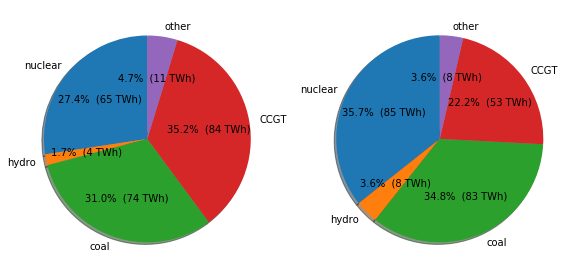

In [52]:
sizes = np.sum(genMatrixR, axis=0)/2.
sizes = sizes[0:5]
labZ = genTypesR[0:5]

explode = (0,0,0,0,0)
fig1, axs = plt.subplots(1,2)
fig1.set_size_inches(8,4)
axs[0].pie(sizes, explode=explode, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
axs[0].axis('equal')

sizes = np.sum(modelMix, axis=0)/2.
sizes = sizes[0:5]
axs[1].pie(sizes, explode=explode, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
axs[1].axis('equal')

plt.tight_layout()
plt.show()

#### average daily parameters

<p>For season winter </p>

* The min nuclear generation is 7.79, the max is 7.83
* The min hydro generation is 0.50, the max is 0.88
* The min coal generation is 10.38, the max is 15.00
* The min CCGT generation is 3.92, the max is 15.17
* The min other generation is 0.93, the max is 1.01
* The min OCGT generation is -0.00, the max is 0.01

<p>For season spring </p>

* The min nuclear generation is 7.20, the max is 7.28
* The min hydro generation is 0.28, the max is 0.56
* The min coal generation is 5.81, the max is 8.48
* The min CCGT generation is 5.09, the max is 11.55
* The min other generation is 0.92, the max is 1.00
* The min OCGT generation is 0.00, the max is 0.00

<p>For season summer </p>

* The min nuclear generation is 7.00, the max is 7.04
* The min hydro generation is 0.17, the max is 0.42
* The min coal generation is 3.91, the max is 6.87
* The min CCGT generation is 5.91, the max is 13.11
* The min other generation is 1.27, the max is 1.34
* The min OCGT generation is 0.00, the max is 0.00

<p>For season autumn </p>

* The min nuclear generation is 7.85, the max is 7.93
* The min hydro generation is 0.41, the max is 0.77
* The min coal generation is 4.65, the max is 10.38
* The min CCGT generation is 4.86, the max is 15.61
* The min other generation is 1.86, the max is 2.00
* The min OCGT generation is 0.00, the max is 0.01

In [53]:
### now use SEASONAL rules - i.e. dispatch and basleoad change by season

plantCapsSeasonal = [np.asarray([[7., 0.5,  8.,  5., 1.5, 0],
                                 [1,  0.5, 10., 20.,  1., 1]]),
                     np.asarray([[7,  0.5,  6.,  5., 1.5, 0],
                                 [1., 0.3,  6., 20., 1. , 1]]),
                     np.asarray([[7,  0.5,  4.,  5., 1.5, 0],
                                 [1., 0.1,  6., 20., 0.5, 1]]),
                     np.asarray([[7., 0.5,  5.,  7., 1.5, 0],
                                 [1., 0.1,  6., 20., 1.0, 1]])]

for j,season in enumerate(seasons):
    print (season+' max generating capacity is %.f'%np.sum(plantCapsSeasonal[j])+'GW')
    print (season+' max demand is %.f'%np.max(demand[seasonMarkers[j]:seasonMarkers[j+1]])+'GW')
modelMix = np.zeros((len(demand),np.size(plantCapsBaseload, 1)))

winter max generating capacity is 56GW
winter max demand is 50GW
spring max generating capacity is 49GW
spring max demand is 36GW
summer max generating capacity is 47GW
summer max demand is 37GW
autumn max generating capacity is 50GW
autumn max demand is 47GW


In [54]:
curtailed = np.zeros(np.shape(demand))
for j in range(len(demand)):
    # get the dispatch based on the demand
    seasonIndex = np.digitize(j, seasonMarkers)-1 
    modelMix[j], curtailed[j] = \
    FCEC_baseload(demand[j], plantCapsBaseload=plantCapsSeasonal[seasonIndex], windPeriod=wind[j])

In [55]:
modelMixSeasonal = np.copy(modelMix)
curtailedSeasonal = np.copy(curtailed)

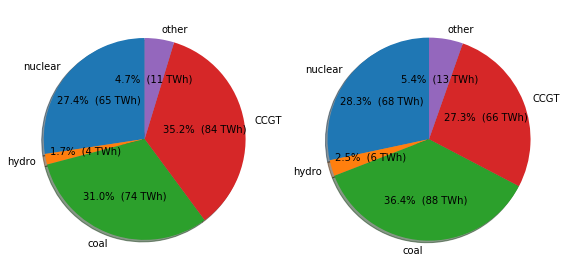

In [56]:
sizes = np.sum(genMatrixR, axis=0)/2.
sizes = sizes[0:5]
labZ = genTypesR[0:5]

explode = (0,0,0,0,0)
fig1, axs = plt.subplots(1,2)
fig1.set_size_inches(8,4)
axs[0].pie(sizes, explode=explode, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
axs[0].axis('equal')

sizes = np.sum(modelMix, axis=0)/2.
sizes = sizes[0:5]
axs[1].pie(sizes, explode=explode, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
axs[1].axis('equal')

plt.tight_layout()
plt.show()

### Now optimise the dispatch function

In [57]:
from scipy.optimize import minimize

In [58]:
#### lets def a function to calculate error between actual dispatch and model
def dispatch_Error(x, demandSeason, windSeason, actualMixSeason):
    plantCapsBaseload = \
    np.asarray([[x[0], x[1], x[2], x[3], x[4], 0], [x[5], x[6], x[7], x[8], x[9], 1]])
    
    modelMix = np.zeros((len(demandSeason),np.size(plantCapsBaseload,1)))
    curtailed = np.zeros((len(windSeason)))
    
    for j in range(len(demandSeason)):
        modelMix[j,:], curtailed[j] = FCEC_baseload(demandSeason[j], plantCapsBaseload, \
                                                windSeason[j])
        
    errorMatrix = modelMix - actualMixSeason
    totalError = np.sum(np.square(errorMatrix))
    
    # add in massive penalty if demand unmet
    demandError = demandSeason - np.sum(modelMix, axis=1) - (windSeason-curtailed)
    demandError = (np.round(demandError*1000)/1000)
    demandError = [e for e in demandError if e>0.1]
    #print(np.sum(demandError))
    
    # add in penalty for wind curtailment
    windError = 2*np.sum(curtailed)
    
    totalError+=(100*np.sum(demandError)+windError)
    return totalError, modelMix

def objective_Fun(x, demandSeason, windSeason, actualMixSeason):
    totalError = dispatch_Error(x, demandSeason, windSeason, actualMixSeason) [0]
    return totalError

In [59]:
x0 = np.zeros((10))
x0[0] = 7. # nuclear base
x0[1] = 0.5 # hydro base
x0[2] = 7. # coal base
x0[3] = 10. # CCGT base
x0[4] = 1. # other base
x0[5] = 1. # nuclear dispatch
x0[6] = 0.1 # hydro dispatch
x0[7] = 8. # coal dispatch
x0[8] = 15. # CCGT dispatch
x0[9] = 1. # other dispatch

In [60]:
### Initially look at the first day
sqErrorInit, modelMixInit = dispatch_Error(x0, demand[0:48], wind[0:48], genMatrixR[0:48])

In [61]:
sqErrorInit

2352.8614239999997

In [62]:
#### add the bounds to the problem
boundsTest = np.array([(6.,9.), # nuclear baseload
                       (0.1,1.5), # hydro baseload
                       (2.,12.), #coal baseload
                       (4.,15.), # CCGT baseload (FRACTIONAL)
                       (0.,2.5), # other baseload
                       (0.,3.), # nuclear dispatch
                       (0.,1.5), # hydro dispatch
                       (5.,18.), #coal dispatch
                       (5.,15.), # CCGT dispatch
                       (0.,2.5)]) # other dispatch

In [63]:
#### add the constraints to the problem
def constraintMax(x, maxDemand):
    # total available capacity must always be greater than max demand
    return total_Avail_Cap(x,maxDemand) - maxDemand

def total_Avail_Cap(x, maxDemand):
    return x[0]+x[1]+x[2]+x[3]+x[4]+x[5]+x[6]+x[7]+x[8]+x[9]+1.

# 20% baseload nuclear must be >= nuclear dispatch
def constraintNuc(x):
    return x[0]*0.2 - x[5]

maxDemand = np.max(demand[0:48])
print(constraintMax(x0, maxDemand))
# ensure always enough cap to meet demand
cons = [{'type':'ineq', 'fun': constraintMax, 'args': (maxDemand,)}, # gen must cover max demand
       {'type':'ineq', 'fun': constraintNuc}] # nuclear can be max 10% flex

16.823000000000008


In [64]:
res = minimize(objective_Fun, x0, args=(demand[0:48], wind[0:48], genMatrixR[0:48]), 
               method='SLSQP', constraints=cons, bounds=boundsTest, options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 47.47829709524665
            Iterations: 13
            Function evaluations: 165
            Gradient evaluations: 13


In [65]:
x = res.x

### Initially look at the first day
sqErrorFinal, modelMixFinal = dispatch_Error(x, demand[0:48], wind[0:48], genMatrixR[0:48])

In [66]:
sqErrorFinal, x

(47.47829709524665,
 array([ 7.75111955,  0.28271188,  4.70272389,  4.        ,  0.89483863,
         0.15329152,  0.11095656,  6.86031254, 15.        ,  1.        ]))

In [67]:
### Look at the day solution

In [68]:
def actual_initial_final_plot( demandArray,actualMixArray,modelMixInitArray,modelMixFinalArray ):
    fig = plt.figure(figsize=(14,14))
    ax1 = fig.add_subplot(331)
    averageDay = average_day(demandArray, actualMixArray, 48)
    bottomsPos = np.zeros(len(averageDay))
    bottomsNeg = np.zeros(len(averageDay))
    for col in range(np.size(averageDay,1)):
        d = averageDay[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        ax1.bar(times, posVal, bottom=bottomsPos, width=0.5, color=colors[col])
        ax1.bar(times, negVal, bottom=bottomsNeg, width=0.5, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
    ax1.set_ylim([0,45])
    labX = 'Hours'
    labY = 'Generation'
    axis_format(ax1, labX, labY, fs)

    ax1 = fig.add_subplot(332)
    averageDay = average_day(demandArray, modelMixInitArray, 48)
    bottomsPos = np.zeros(len(averageDay))
    bottomsNeg = np.zeros(len(averageDay))
    for col in range(np.size(averageDay,1)):
        d = averageDay[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        ax1.bar(times, posVal, bottom=bottomsPos, width=0.5, color=colors[col])
        ax1.bar(times, negVal, bottom=bottomsNeg, width=0.5, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
    ax1.set_ylim([0,45])
    labX = 'Hours'
    labY = 'Generation'
    axis_format(ax1, labX, labY, fs)

    ax1 = fig.add_subplot(333)
    averageDay = average_day(demandArray, modelMixFinalArray, 48)
    bottomsPos = np.zeros(len(averageDay))
    bottomsNeg = np.zeros(len(averageDay))
    for col in range(np.size(averageDay,1)):
        d = averageDay[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        ax1.bar(times, posVal, bottom=bottomsPos, width=0.5, color=colors[col])
        ax1.bar(times, negVal, bottom=bottomsNeg, width=0.5, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
    ax1.set_ylim([0,45])
    labX = 'Hours'
    labY = 'Generation'
    axis_format(ax1, labX, labY, fs)
    
    centres, dispatchAverage = dispatch_by_demand(demandArray, actualMixArray)
    ax2 = fig.add_subplot(334)
    bottomsPos = np.zeros(len(dispatchAverage))
    bottomsNeg = np.zeros(len(dispatchAverage))
    for col in range(np.size(dispatchAverage,1)):
        d = dispatchAverage[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        ax2.bar(centres, posVal, bottom=bottomsPos, width=1, color=colors[col])
        ax2.bar(centres, negVal, bottom=bottomsNeg, width=1, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
    ax2.set_ylim([0,55])
    labX = 'Demand'
    labY = 'Generation'
    axis_format(ax2, labX, labY, fs)
    
    centres, dispatchAverage = dispatch_by_demand(demandArray, modelMixInitArray)
    ax2 = fig.add_subplot(335)
    bottomsPos = np.zeros(len(dispatchAverage))
    bottomsNeg = np.zeros(len(dispatchAverage))
    for col in range(np.size(dispatchAverage,1)):
        d = dispatchAverage[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        ax2.bar(centres, posVal, bottom=bottomsPos, width=1, color=colors[col])
        ax2.bar(centres, negVal, bottom=bottomsNeg, width=1, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
    ax2.set_ylim([0,55])
    labX = 'Demand'
    labY = 'Generation'
    axis_format(ax2, labX, labY, fs)
    
    centres, dispatchAverage = dispatch_by_demand(demandArray, modelMixFinalArray)
    ax2 = fig.add_subplot(336)
    bottomsPos = np.zeros(len(dispatchAverage))
    bottomsNeg = np.zeros(len(dispatchAverage))
    for col in range(np.size(dispatchAverage,1)):
        d = dispatchAverage[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        ax2.bar(centres, posVal, bottom=bottomsPos, width=1, color=colors[col])
        ax2.bar(centres, negVal, bottom=bottomsNeg, width=1, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
    ax2.set_ylim([0,55])
    labX = 'Demand'
    labY = 'Generation'
    axis_format(ax2, labX, labY, fs)
    
    ax1 = fig.add_subplot(337)
    sizes = np.sum(actualMixArray, axis=0)/2.
    sizes = sizes[0:5]
    ax1.pie(sizes, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
    ax1.axis('equal')    

    ax1 = fig.add_subplot(338)
    sizes = np.sum(modelMixInitArray, axis=0)/2.
    sizes = sizes[0:5]
    ax1.pie(sizes, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
    ax1.axis('equal')    
    
    ax1 = fig.add_subplot(339)
    sizes = np.sum(modelMixFinalArray, axis=0)/2.
    sizes = sizes[0:5]
    ax1.pie(sizes, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
    ax1.axis('equal')    
    
    fig.tight_layout

In [69]:
# actual_initial_final_plot(demand[0:48], genMatrixR[0:48], modelMixInit, modelMixFinal)

### Set up the optimisation for each season

* Initially we keep the same bounds
* The initial guess for each season is as used in the seasonal flex dispatch

In [136]:
#### initial guesses
plantCapsSeasonal = [np.asarray([[7., 0.5,  8.,  5., 1.5, 0],
                                 [1,  0.5, 10., 20.,  1., 1]]),
                     np.asarray([[7,  0.5,  6.,  5., 1.5, 0],
                                 [1., 0.3,  6., 20., 1. , 1]]),
                     np.asarray([[7,  0.5,  4.,  5., 1.5, 0],
                                 [1., 0.1,  6., 20., 0.5, 1]]),
                     np.asarray([[7., 0.5,  5.,  7., 1.5, 0],
                                 [1., 0.1,  6., 20., 1.0, 1]])]

In [137]:
#### add the bounds to the problem
boundsTest = np.array([(4.,9.), # nuclear baseload
                       (0.,1.5), # hydro baseload
                       (2.,12.), #coal baseload
                       (3.,15.), # CCGT baseload
                       (0.,2.5), # other baseload
                       (0.,3.), # nuclear dispatch
                       (0.,1.5), # hydro dispatch
                       (3.,18.), #coal dispatch
                       (5.,27.), # CCGT dispatch
                       (0.,2.5)]) # other dispatch

In [138]:
optimalParams = [np.zeros((np.shape(plantCapsSeasonal[0]))) for j in range(4)]

### Use the cell below to run the optimisation and get the optimal baseload and dispatchable components

In [157]:
# for j,season in enumerate(seasons): 
#     print (season)
#     demandSeason = demand[seasonMarkers[j]:seasonMarkers[j+1]]
#     windSeason = wind[seasonMarkers[j]:seasonMarkers[j+1]]
#     genMatrixRSeason = genMatrixR[seasonMarkers[j]:seasonMarkers[j+1]]

#     # define the initial guess for that season
#     xInitial = np.zeros(np.shape(x0))
#     xInitial[0:5] = plantCapsSeasonal[j][0][0:5]
#     xInitial[5:] = plantCapsSeasonal[j][1][0:5]

#     # for the constraints
#     maxDemand = np.max(demandSeason)

#     res = minimize(objective_Fun, xInitial, args=(demandSeason, windSeason, genMatrixRSeason), 
#                method='SLSQP', constraints=cons, bounds=boundsTest, options={'disp': True})

#     sqErrorInit, modelMixInit = dispatch_Error(xInitial, demandSeason, windSeason, genMatrixRSeason)
#     print('the initial error is %.2f'%sqErrorInit)

#     xFinal = res.x

#     sqErrorFinal, modelMixFinal = dispatch_Error(xFinal, demandSeason, windSeason, genMatrixRSeason)
#     print('the final error is %.2f'%sqErrorFinal)

#     actual_initial_final_plot(demandSeason, genMatrixRSeason, modelMixInit, modelMixFinal)
    
#     optimalParams[j][0,0:5] = xFinal[0:5]
#     optimalParams[j][1,0:5] = xFinal[5:]


### Load the pre-saved optimal baseload/dispatchable components

In [70]:
with open('IntermediateData/optimalParams.pickle', 'rb') as pickleFile:
    optimalParams = pickle.load(pickleFile)

In [71]:
for j,season in enumerate(seasons):
    print (season+' max generating capacity is %.f'%np.sum(optimalParams[j])+'GW')
    print (season+' max demand is %.f'%np.max(demand[seasonMarkers[j]:seasonMarkers[j+1]])+'GW')
    print (season+' max demand net wind is %.f'%np.max(demandNetWind[seasonMarkers[j]:seasonMarkers[j+1]])+'GW')
modelMix = np.zeros((len(demand),np.size(plantCapsBaseload, 1)))

curtailed = np.zeros(np.shape(demand))
for j in range(len(demand)):
    # get the dispatch based on the demand
    seasonIndex = np.digitize(j, seasonMarkers)-1 
    modelMix[j], curtailed[j] = \
    FCEC_baseload(demand[j], plantCapsBaseload=optimalParams[seasonIndex], windPeriod=wind[j])

winter max generating capacity is 48GW
winter max demand is 50GW
winter max demand net wind is 49GW
spring max generating capacity is 44GW
spring max demand is 36GW
spring max demand net wind is 35GW
summer max generating capacity is 42GW
summer max demand is 37GW
summer max demand net wind is 36GW
autumn max generating capacity is 46GW
autumn max demand is 47GW
autumn max demand net wind is 45GW


In [72]:
np.sum(curtailed)/np.sum(wind)

0.00694753068467633

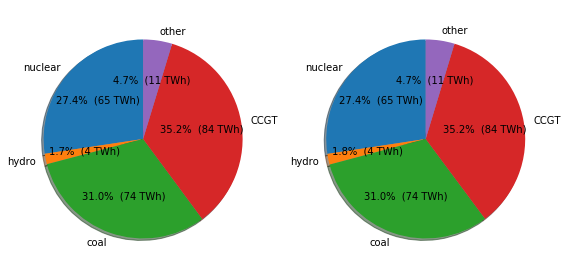

In [259]:
sizes = np.sum(genMatrixR, axis=0)/2.
sizes = sizes[0:5]
labZ = genTypesR[0:5]

explode = (0,0,0,0,0)
fig1, axs = plt.subplots(1,2)
fig1.set_size_inches(8,4)
axs[0].pie(sizes, explode=explode, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
axs[0].axis('equal')

sizes = np.sum(modelMix, axis=0)/2.
sizes = sizes[0:5]
axs[1].pie(sizes, explode=explode, labels=labZ, autopct=make_autopct(sizes), shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
axs[1].axis('equal')

plt.tight_layout()
plt.show()

In [260]:
optimalParams

[array([[ 6.67678743,  0.33915773,  7.37191404,  4.00702171,  0.90793107,
          0.        ],
        [ 1.20310709,  0.30545878,  7.25274178, 18.09787155,  1.58350884,
          0.        ]]),
 array([[ 6.07905524,  0.        ,  3.48249253,  5.63320369,  0.95910663,
          0.        ],
        [ 1.21581105,  0.45483825,  5.03590683, 20.        ,  1.        ,
          0.        ]]),
 array([[6.06982067e+00, 6.58415766e-10, 2.64309192e+00, 6.29959171e+00,
         1.30285448e+00, 0.00000000e+00],
        [9.97533257e-01, 3.38900122e-01, 3.85238905e+00, 2.00000000e+01,
         5.00000000e-01, 0.00000000e+00]]),
 array([[ 7.07330165,  0.        ,  2.39073453,  5.66981844,  1.94526301,
          0.        ],
        [ 0.8822337 ,  0.5879426 ,  6.70327887, 20.        ,  1.        ,
          0.        ]])]

In [261]:
plotMix = np.zeros((np.shape(modelMix)[0],7))
plotMix[:,0:6], plotMix[:,6] = genMatrixR, wind

### If have not already then save the reduced genMatrix and the optimal params from the model

In [73]:
# with open('./IntermediateData/reducedGenMatrix.pickle', 'wb') as pickleFile:
#     pickle.dump(plotMix, pickleFile)
# with open('./IntermediateData/optimalParams.pickle', 'wb') as pickleFile:
#     pickle.dump(optimalParams, pickleFile)

In [74]:
colors = sns.color_palette()

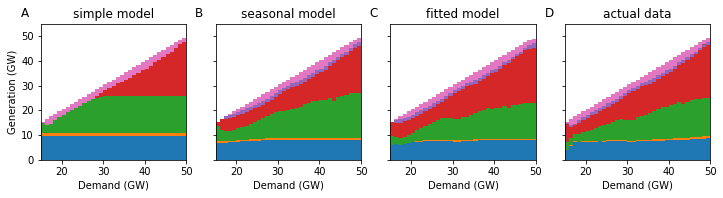

In [75]:
## first figure for the paper

def make_autopct1(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0)/1000)
        #return '{p:.1f}%  ({v:d} TWh)'.format(p=pct,v=val)
        return '{v:d} TWh'.format(v=val)
    return my_autopct

fig = plt.figure(figsize=(12,2.5))
axs = []
for j in range(4):
    ax = fig.add_subplot(1,4,j+1)
    axs.append( ax )
    
figLabels = ['A', 'B', 'C', 'D']
titles = ['simple model', 'seasonal model', 'fitted model', 'actual data']

for j in range(4):
    if j == 0:
        plotMix = np.zeros((np.shape(modelMix)[0],7))
        plotMix[:,0:6], plotMix[:,6] = modelMixNaive, wind
        centres, dispatchAverage = dispatch_by_demand(demand, plotMix)
    if j == 1:
        plotMix[:,0:6], plotMix[:,6] = modelMixSeasonal, (wind-curtailedSeasonal)
        centres, dispatchAverage = dispatch_by_demand(demand, plotMix)
    if j == 2:
        plotMix[:,0:6], plotMix[:,6] = modelMix, (wind-curtailed)
        centres, dispatchAverage = dispatch_by_demand(demand, plotMix)
    if j == 3:
        plotMix[:,0:6], plotMix[:,6] = genMatrixR, wind
        centres, dispatchAverage = dispatch_by_demand(demand, plotMix)
    bottomsPos = np.zeros(len(dispatchAverage))
    bottomsNeg = np.zeros(len(dispatchAverage))
    for col in range(np.size(dispatchAverage,1)):
        d = dispatchAverage[:,col]
        posVal = np.zeros(np.shape(d))
        negVal = np.zeros(np.shape(d))
        posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
        negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
        axs[j].bar(centres, posVal, bottom=bottomsPos, width=1, color=colors[col])
        axs[j].bar(centres, negVal, bottom=bottomsNeg, width=1, color=colors[col])
        bottomsPos+=posVal
        bottomsNeg+=negVal
    labX = 'Demand (GW)'
    if j==0:
        labY = 'Generation (GW)'
    else:
        labY = ''
        axs[j].set_yticklabels([])
    axis_format(axs[j], labX, labY, fs)
    
    axs[j].set_yticks(np.arange(0,55,10))
    axs[j].set_ylim([0,55])
    axs[j].set_xlim([min(centres)-0.5,max(centres)+0.5])
    axs[j].text(-0.14, 1.05, figLabels[j], transform=axs[j].transAxes, fontsize=fs+2) 
    axs[j].set_title(titles[j])


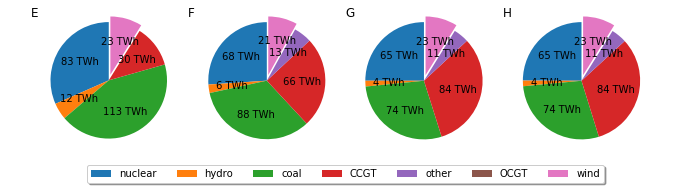

In [76]:
figLabels = ['E', 'F', 'G', 'H']

fig = plt.figure(figsize=(12,2.5))
axs = []
for j in range(4):
    ax = fig.add_subplot(1,4,j+1)
    axs.append( ax )

for j in range(4):
    if j == 0:
        plotMix = np.zeros((np.shape(modelMix)[0],7))
        plotMix[:,0:6], plotMix[:,6] = modelMixNaive, wind
    if j == 1:
        plotMix[:,0:6], plotMix[:,6] = modelMixSeasonal, (wind-curtailedSeasonal)
    if j == 2:
        plotMix[:,0:6], plotMix[:,6] = modelMix, (wind-curtailed)
    if j == 3:
        plotMix[:,0:6], plotMix[:,6] = genMatrixR, wind   
    if j==0:
        sizes = np.sum(plotMix, axis=0)/2.
        keep = np.array([0,1,2,3,6])
        sizes = sizes[keep]
        explode = (0,0,0,0,0.1)
        labZW = ['nuclear', 'hydro', 'coal', 'CCGT', 'wind']
    else:
        sizes = np.sum(plotMix, axis=0)/2.
        keep = np.array([0,1,2,3,4,6])
        sizes = sizes[keep]
        explode = (0,0,0,0,0,0.1)
        labZW = ['nuclear', 'hydro', 'coal', 'CCGT', 'other', 'wind']
    axs[j].pie(sizes, explode=explode, autopct=make_autopct1(sizes), shadow=False, startangle=90,
              colors=[colors[i] for i in keep])
    # Equal aspect ratio ensures that pie is drawn as a circle
    axs[j].axis('equal')
    
fig.subplots_adjust(wspace=-0.2)

for j in range(4):
    axs[j].text(0.1, 0.95, figLabels[j], transform=axs[j].transAxes, fontsize=fs+2)

labZW = ['nuclear', 'hydro', 'coal', 'CCGT', 'other', 'OCGT', 'wind']
rects = []
for col in range(7):
    r = plt.Rectangle((0, 0), 1, 1, fc=colors[col], alpha=1)
    rects.append(r)
axs[1].legend(rects, labZW, loc='upper center', bbox_to_anchor=(0.9, -0.1),
          fancybox=True, shadow=True, ncol=7)

In [77]:
test = curtailed.reshape(365,48)
test = np.sum(test, axis=1)
np.max(test)

26.91738190565934

In [78]:
np.where(test==max(test))

(array([234], dtype=int64),)

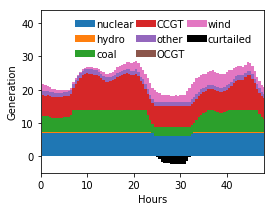

In [79]:
##### Figure 2 in paper
times = np.arange(0.5,48.1,0.5)
fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111)
bottomsPos = np.zeros(len(times))
bottomsNeg = np.zeros(len(times))

start, end = 233*48, 235*48
days = np.zeros((96,7))
days[:,0:6] = modelMix[start:end,:]
days[:,6] = wind[start:end] - curtailed[start:end]

for col in range(np.size(days,1)):
    d = days[:,col]
    posVal = np.zeros(np.shape(d))
    negVal = np.zeros(np.shape(d))
    posVal[np.where(d>0)[0]] = d[np.where(d>0)[0]]
    negVal[np.where(d<0)[0]] = d[np.where(d<0)[0]]
    ax1.bar(times, posVal, bottom=bottomsPos, width=0.5, color=colors[col])
    ax1.bar(times, negVal, bottom=bottomsNeg, width=0.5, color=colors[col])
    bottomsPos+=posVal
    bottomsNeg+=negVal
ax1.bar(times, -curtailed[start:end], width=0.5, color='k')
ax1.set_ylim([-5,44])
ax1.set_xlim([0,48])
labX = 'Hours'
labY = 'Generation'
axis_format(ax1, labX, labY, fs)

labZW = ['nuclear', 'hydro', 'coal', 'CCGT', 'other', 'OCGT', 'wind', 'curtailed']
rects = []
for col in range(7):
    r = plt.Rectangle((0, 0), 1, 1, fc=colors[col], alpha=1)
    rects.append(r)
r = plt.Rectangle((0, 0), 1, 1, fc='k', alpha=1)
rects.append(r)
ax1.legend(rects, labZW, loc='upper center', bbox_to_anchor=(0.55, 1.),
          fancybox=True, shadow=True, ncol=3, frameon=False, columnspacing=0.2, handletextpad=0.1)